In [68]:
###
#1. define data analysis and workflow
###

#imporing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller, kpss

In [69]:
#Load the raw data
try:
    df = pd.read_csv('../data/raw/BrentOilPrices.csv', parse_dates=['Date'], index_col='Date')
    print("File loaded successfully.") 
except FileNotFoundError:
    print("File not found. Please check the file path.")
df.head()

C:\Users\HP EliteBook\AppData\Local\Temp\ipykernel_16476\2295110468.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('../data/raw/BrentOilPrices.csv', parse_dates=['Date'], index_col='Date')


File loaded successfully.


,Price
Date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63


In [70]:
#sort the dataframe by date
df = df.sort_index()
df = df.asfreq('D')
df["Price"] = df["Price"].interpolate()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12963 entries, 1987-05-20 to 2022-11-14
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   12963 non-null  float64
dtypes: float64(1)
memory usage: 202.5 KB


In [71]:
#handling missing values
df = df.dropna()
print(f"Missing values after handling: {df.isnull().sum().sum()}")
print(df.describe())

Missing values after handling: 0
              Price
count  12963.000000
mean      48.523273
std       32.976876
min        9.100000
25%       19.050000
50%       38.753333
75%       70.353333
max      143.950000


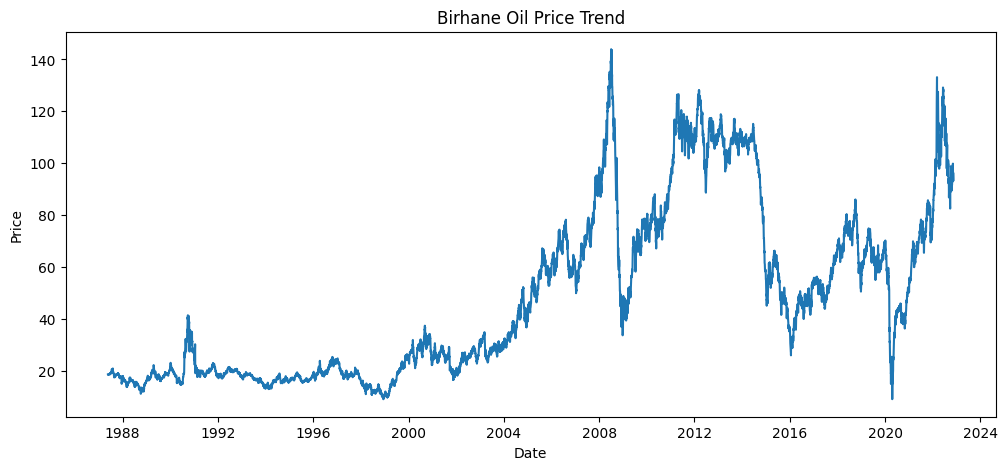

In [72]:
#price Trend
plt.figure(figsize=(12,5))
plt.plot(df.index, df["Price"])
plt.title("Birhane Oil Price Trend")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()


In [73]:
# Create event table
events_data = {
    "Date": [
        "2014-11-27", "2016-01-16", "2016-11-30", "2018-05-08",
        "2019-09-14", "2020-03-11", "2020-04-12", "2021-11-26",
        "2022-02-24", "2022-03-08", "2022-10-05", "2023-04-02",
        "2023-10-07", "2024-06-02"
    ],
    "Event": [
        "OPEC keeps production high",
        "Iran sanctions lifted",
        "OPEC production cut agreement",
        "US exits Iran nuclear deal",
        "Saudi Aramco attacked",
        "COVID-19 declared pandemic",
        "OPEC+ historic cut",
        "Omicron variant shock",
        "Russia invades Ukraine",
        "US bans Russian oil",
        "OPEC+ output cuts",
        "Surprise OPEC+ cut",
        "Middle East conflict",
        "OPEC+ extends cuts"
    ]
}

events = pd.DataFrame(events_data)
events["Date"] = pd.to_datetime(events["Date"])
events.to_csv("../data/events/events.csv", index=False)

print(events)

         Date                          Event
0  2014-11-27     OPEC keeps production high
1  2016-01-16          Iran sanctions lifted
2  2016-11-30  OPEC production cut agreement
3  2018-05-08     US exits Iran nuclear deal
4  2019-09-14          Saudi Aramco attacked
5  2020-03-11     COVID-19 declared pandemic
6  2020-04-12             OPEC+ historic cut
7  2021-11-26          Omicron variant shock
8  2022-02-24         Russia invades Ukraine
9  2022-03-08            US bans Russian oil
10 2022-10-05              OPEC+ output cuts
11 2023-04-02             Surprise OPEC+ cut
12 2023-10-07           Middle East conflict
13 2024-06-02             OPEC+ extends cuts


In [74]:
#attach data to the event 
df["Event"] = 0

for d in events["Date"]:
    if d in df.index:
        df.loc[d, "Event"] = 1

In [75]:
# create event window
window = 5

for d in events["Date"]:
    df.loc[d - pd.Timedelta(days=window): d + pd.Timedelta(days=window), "Event"] = 1

#comparing event with normal data
event_days = df[df["Event"] == 1]["Price"]
normal_days = df[df["Event"] == 0]["Price"]

print("Event Mean Price:", event_days.mean())
print("Normal Mean Price:", normal_days.mean())


Event Mean Price: 67.35588154269973
Normal Mean Price: 48.34582840159893


In [76]:
stat, p, _, _ = kpss(df["Price"], regression='c')
print("KPSS Statistic:", stat)
print("KPSS p-value:", p)

for d in events["Date"]:
    start = d - pd.Timedelta(days=window)
    end = d + pd.Timedelta(days=window)
    df.loc[start:end, "Event"] = 1

KPSS Statistic: 11.177756700403952
KPSS p-value: 0.01


C:\Users\HP EliteBook\AppData\Local\Temp\ipykernel_16476\1176085188.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  stat, p, _, _ = kpss(df["Price"], regression='c')


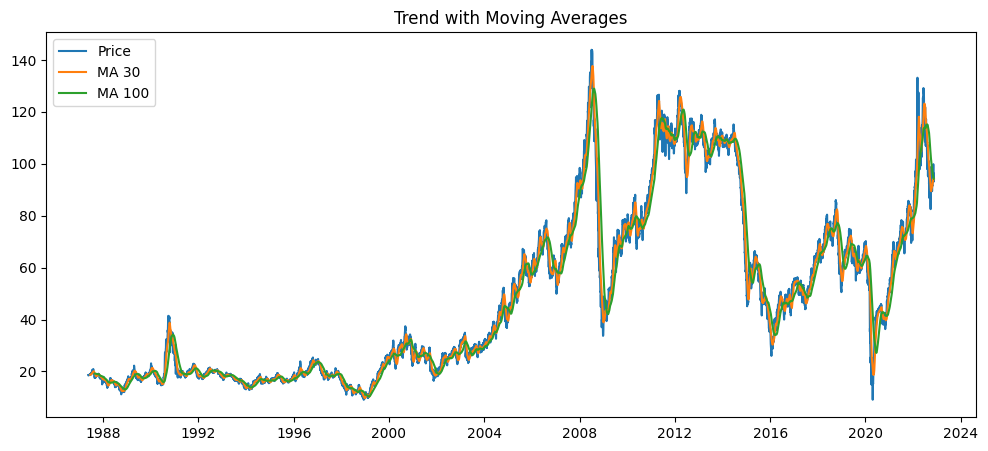

In [77]:
###
#2. Understanding the Model and Data:
###

# trend analysis
df["MA_30"] = df["Price"].rolling(30).mean()
df["MA_100"] = df["Price"].rolling(100).mean()

plt.figure(figsize=(12,5))
plt.plot(df["Price"], label="Price")
plt.plot(df["MA_30"], label="MA 30")
plt.plot(df["MA_100"], label="MA 100")
plt.legend()
plt.title("Trend with Moving Averages")
plt.show()


In [78]:
#create return
df["Return"] = df["Price"].pct_change()
df = df.dropna()

In [79]:
#ADF test in price
adf_price = adfuller(df["Price"])
print("ADF Test on Price")
print("ADF Price Statistic:", adf_price[0])
print("ADF Price p-value:", adf_price[1])

print()
#ADF test on Return
adf_return = adfuller(df["Return"])
print("ADF Test on Return")
print("ADF Return Statistic:", adf_return[0])
print("ADF Return p-value:", adf_return[1])


ADF Test on Price
ADF Price Statistic: -1.9571743202426526
ADF Price p-value: 0.30566039263583134

ADF Test on Return
ADF Return Statistic: -19.594962313846267
ADF Return p-value: 0.0


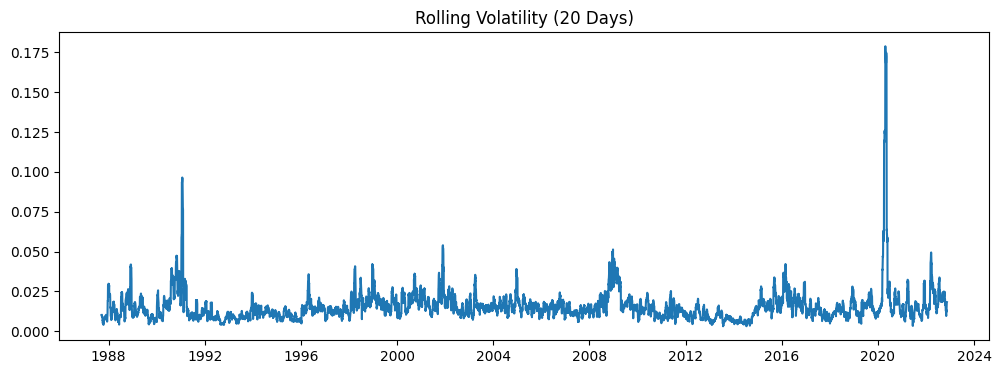

In [80]:
# volatility pattern
df["Volatility"] = df["Return"].rolling(20).std()

plt.figure(figsize=(12,4))
plt.plot(df["Volatility"])
plt.title("Rolling Volatility (20 Days)")
plt.show()

In [81]:
#prepare for change point model
series = df["Price"].values

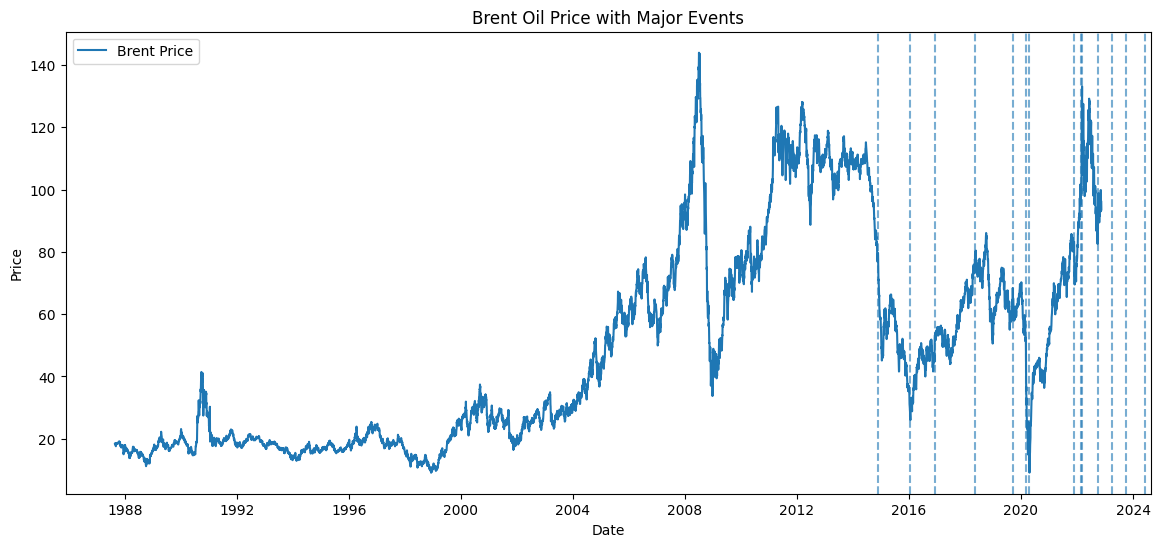

In [82]:
#price chart with event lines
plt.figure(figsize=(14,6))
plt.plot(df.index, df["Price"], label="Brent Price")

for d in events["Date"]:
    plt.axvline(d, linestyle="--", alpha=0.6)

plt.title("Brent Oil Price with Major Events")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


In [83]:
df["Return"] = df["Price"].pct_change()
df["Volatility"] = df["Return"].rolling(20).std()
df["MA_30"] = df["Price"].rolling(30).mean()
df["MA_100"] = df["Price"].rolling(100).mean()

df = df.dropna()
print(df.columns)

Index(['Price', 'Event', 'MA_30', 'MA_100', 'Return', 'Volatility'], dtype='object')


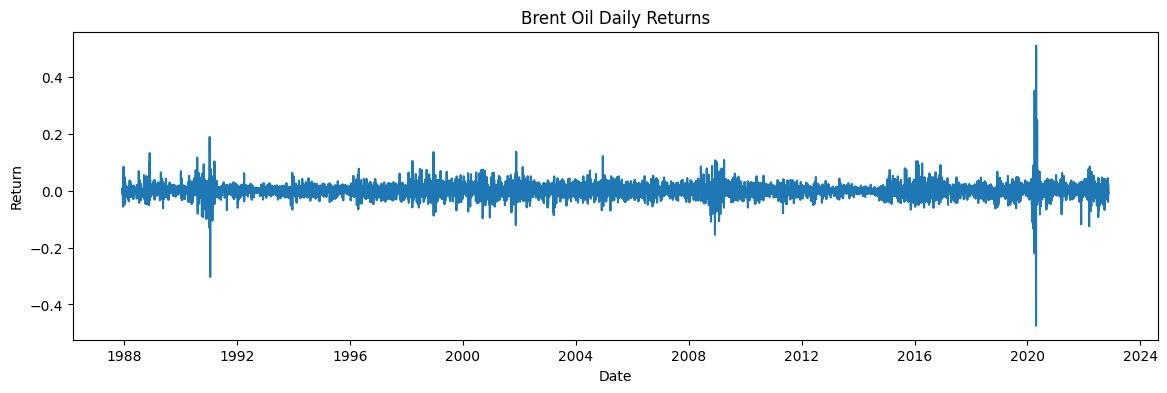

In [84]:
#return time series plot
plt.figure(figsize=(14,4))
plt.plot(df.index, df["Return"])
plt.title("Brent Oil Daily Returns")
plt.xlabel("Date")
plt.ylabel("Return")
plt.show()


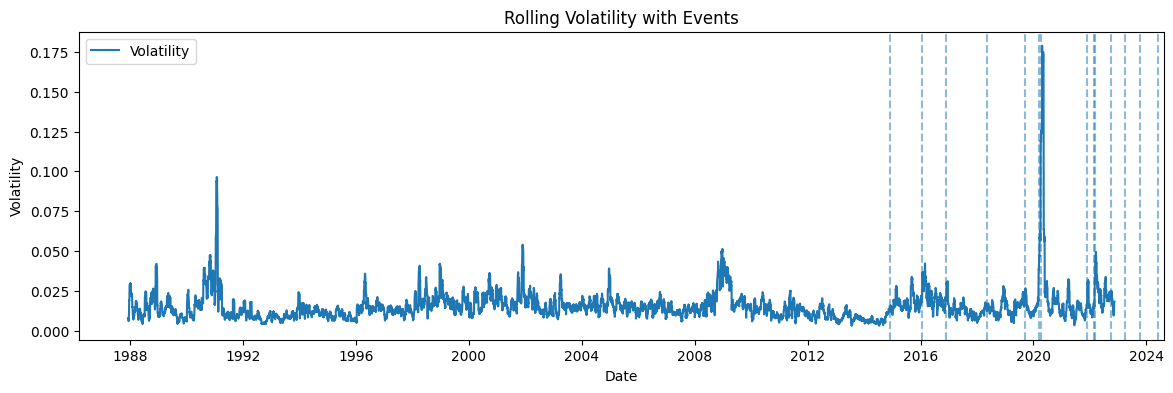

In [85]:
#volatile with event
plt.figure(figsize=(14,4))
plt.plot(df.index, df["Volatility"], label="Volatility")

for d in events["Date"]:
    plt.axvline(d, linestyle="--", alpha=0.5)

plt.title("Rolling Volatility with Events")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()


C:\Users\HP EliteBook\AppData\Local\Temp\ipykernel_16476\2703857157.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([event_returns, normal_returns], labels=["Event Days", "Normal Days"])


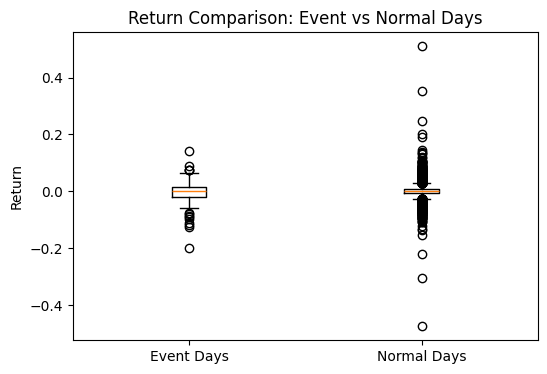

In [86]:
#event with normal
event_returns = df[df["Event"] == 1]["Return"]
normal_returns = df[df["Event"] == 0]["Return"]

plt.figure(figsize=(6,4))
plt.boxplot([event_returns, normal_returns], labels=["Event Days", "Normal Days"])
plt.title("Return Comparison: Event vs Normal Days")
plt.ylabel("Return")
plt.show()


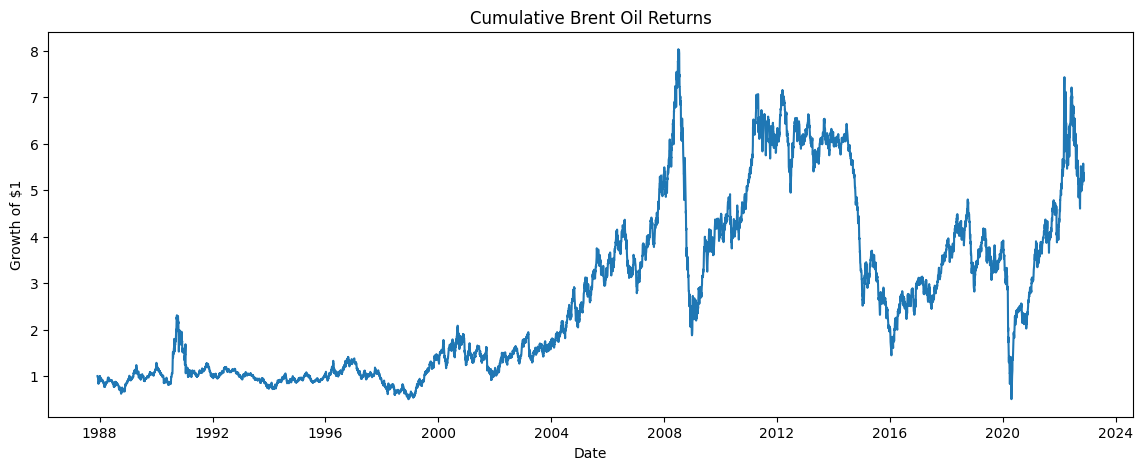

In [87]:
#commulative return plot
df["Cumulative_Return"] = (1 + df["Return"]).cumprod()

plt.figure(figsize=(14,5))
plt.plot(df.index, df["Cumulative_Return"])
plt.title("Cumulative Brent Oil Returns")
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.show()


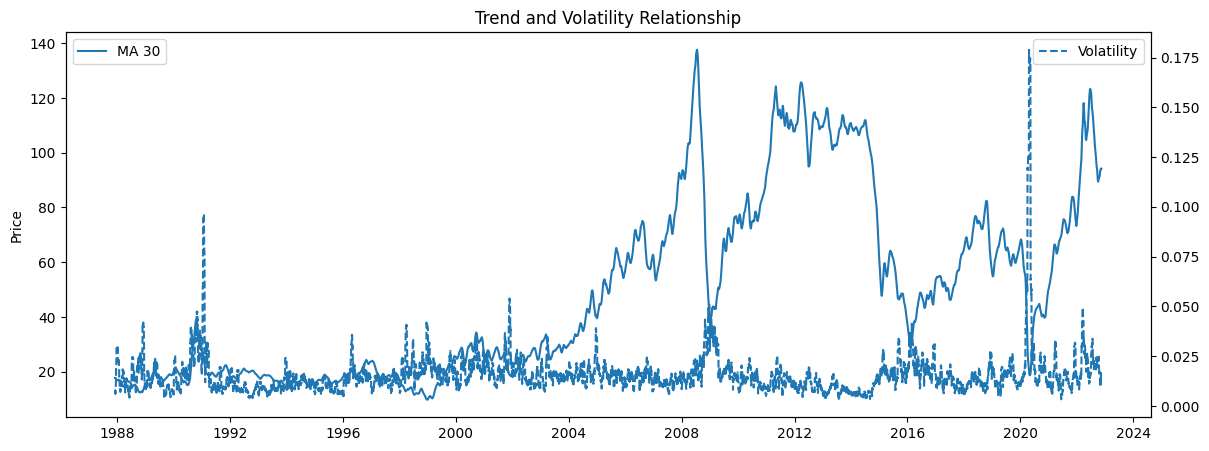

In [88]:
#rolling mean with volatile
fig, ax1 = plt.subplots(figsize=(14,5))

ax1.plot(df.index, df["MA_30"], label="MA 30")
ax1.set_ylabel("Price")

ax2 = ax1.twinx()
ax2.plot(df.index, df["Volatility"], linestyle="--", label="Volatility")

ax1.set_title("Trend and Volatility Relationship")

ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.show()
